In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numdifftools
import scipy.optimize
import numpy as np
import yaml
import os
import uncertainties
import scipy.stats
import scipy.integrate

In [3]:
def init_plot_style():
    """Define the rcParams for the plot. Requires matplotlib to be imported as mpl."""
    my_rc_params = {
        "xtick.direction": "out",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "out",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 0,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 11,
        "axes.grid": False,
        "ytick.right": False,
        "xtick.top": False
    }
    for key in my_rc_params.keys():
        mpl.rcParams[key] = my_rc_params[key]

init_plot_style()

# B to Rho

In [4]:
# Measurements are given as deltaGamma / deltaq2
from epsfits.measurements import BaBarBToRho, BelleBToRho

babarBToRho = BaBarBToRho()
babar_bins = babarBToRho.bins
babar_central = babarBToRho.central *1e18 
babar_covariance = babarBToRho.covariance *1e18 *1e18

belleBToRho = BelleBToRho()
belle_bins = belleBToRho.bins
belle_central = belleBToRho.central *1e18
belle_covariance = belleBToRho.covariance *1e18 *1e18

# Pick most granular binning as the legacy binning
legacy_bins = np.array(belleBToRho.charged_bins)

# Required for plotting
belle_charged_bins = belleBToRho.charged_bins
belle_charged_central = belleBToRho.charged_central *1e18 
belle_charged_covariance = belleBToRho.charged_covariance *1e18 *1e18

belle_neutral_bins = belleBToRho.neutral_bins
belle_neutral_central = belleBToRho.neutral_central *1e18
belle_neutral_covariance = belleBToRho.neutral_covariance *1e18 *1e18

In [5]:
# Calculate the inverse only once, not at every optimization step
babar_inverse = np.linalg.inv(babar_covariance)
belle_inverse = np.linalg.inv(belle_covariance)

In [6]:
def chi2(x):
    """x[0]: Averages measurement. Size of vector should be number of bins in finest spectrum"""
    n = len(legacy_bins)
    belle_res = np.array([
        *(belle_central[0:n] - x),
        belle_central[n+0] - sum(x[0:2])/2,
        belle_central[n+1] - sum(x[2:4])/2,
        belle_central[n+2] - sum(x[4:6])/2,
        belle_central[n+3] - sum(x[6:8])/2,
        belle_central[n+4] - sum(x[8:10])/2,
        belle_central[n+5] - x[10]
    ])
    
    babar_res = np.array([
        babar_central[0] - sum(x[0:4])/4,
        babar_central[1] - sum(x[4:8])/4,
        babar_central[2] - sum(x[8:11])/3
    ])    
    
    return belle_res @ belle_inverse @ belle_res + babar_res @ babar_inverse @ babar_res

In [7]:
%%time
result = scipy.optimize.minimize(
    chi2, x0=np.array(belle_charged_central),
    # x0=np.array(11*[0]),
    method='Nelder-Mead', tol=1e-7, options={'maxiter': 1e7}
)

result.covariance = np.linalg.inv(numdifftools.Hessian(chi2)(result.x)/2) 

CPU times: user 531 ms, sys: 169 ms, total: 700 ms
Wall time: 489 ms


In [8]:
legacy_central = result.x
legacy_covariance = result.covariance

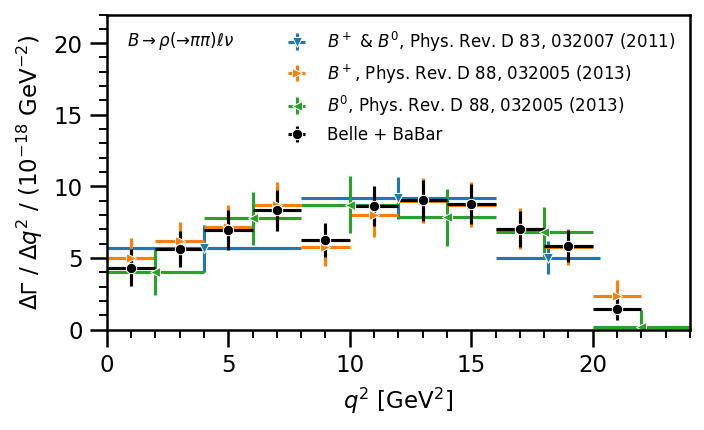

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in babar_bins],
    [c for c in babar_central],
    yerr=[np.sqrt(babar_covariance[i, i]) for i in range(0, len(babar_bins))],
    xerr=[((b[1] - b[0]) / 2) for b in babar_bins],
    marker='v', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$ & $B^0$, Phys. Rev. D 83, 032007 (2011)',
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in belle_charged_bins],
    [c for c in belle_charged_central],
    yerr=[np.sqrt(belle_charged_covariance[i, i]) for i in range(0, len(belle_charged_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in belle_charged_bins],
    marker='>', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$, Phys. Rev. D 88, 032005 (2013)'
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in belle_neutral_bins],
    [c for c in belle_neutral_central],
    yerr=[np.sqrt(belle_neutral_covariance[i, i]) for i in range(0, len(belle_neutral_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in belle_neutral_bins],
    marker='<', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^0$, Phys. Rev. D 88, 032005 (2013)'
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

ax.set_xlim(0, 24)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("../legacy_spectra/legacy_spectrum_rho.png")
plt.savefig("../legacy_spectra/legacy_spectrum_rho.pdf")
plt.show()
plt.close()

In [10]:
legacy_spectrum = {
    "bins": legacy_bins.tolist(),
    "central_values": legacy_central.tolist(),
    "uncertainties": (legacy_covariance.diagonal()**0.5).tolist(),
    "covariance_matrix": legacy_covariance.tolist(),
    "correlation_matrix": (legacy_covariance / np.outer(legacy_covariance.diagonal()**0.5, legacy_covariance.diagonal()**0.5)).tolist()
}

In [11]:
os.makedirs("../legacy_spectra", exist_ok=True)

with open("../legacy_spectra/legacy_spectrum_rho.yaml", "w") as f:
    yaml.dump(legacy_spectrum, f)

# B to Omega

We need to rely on some model to average the omega spectrum, because the bin borders do not match for 
the Belle and BaBar measurement. Here, we decide to use the most recent LCSR calculation as model input
to split the binning, and include this as a nuisance parameter in to the averaging fit.

The way the model dependence is introduced is independet of the value for Vub we use, as it cancels in all 
calculated variables. We use the HFLAV value from B -> pi l nu for plotting purpose.

In [12]:
# Measurements are given as deltaGamma / deltaq2
from epsfits.measurements import BaBarBToOmega, BelleBToOmega

babarBToOmega = BaBarBToOmega()
babar_bins = babarBToOmega.bins
babar_central = babarBToOmega.central *1e18 
babar_covariance = babarBToOmega.covariance *1e18 *1e18 

belleBToOmega = BelleBToOmega()
belle_bins = belleBToOmega.bins
belle_central = belleBToOmega.central *1e18 
belle_covariance = belleBToOmega.covariance *1e18 *1e18 

# Pick most granular binning as the legacy binning
legacy_bins = np.array(babar_bins)

In [13]:
# Calculate the inverse only once, not at every optimization step
babar_inverse = np.linalg.inv(babar_covariance)
belle_inverse = np.linalg.inv(belle_covariance)

In [14]:
from eFFORT.SLBToU.BToVLNu import BToVLNuBCL
from eFFORT.utility import PDG

lcsr_coefficients = np.load('../../eFFORT/data/B{}_LCSR_central.npy'.format("omega"))
lcsr_coefficients_cov = np.load('../../eFFORT/data/B{}_LCSR_covariance.npy'.format("omega"))

m_V = 0.78265 
V_ub = 3.65e-3  # +- 0.09 +- 0.11 
lcsr_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=V_ub)

# The toy results are looking good, very Gaussian
prandom = scipy.stats.multivariate_normal.rvs(mean=lcsr_coefficients, cov=lcsr_coefficients_cov, size=5000)
q2max = lcsr_BToVLNuBCL.q2max

def wrapper(x, pran):
    lcsr_BToVLNuBCL.coefficients = pran
    return lcsr_BToVLNuBCL.dGamma_dq2(x)

In [15]:
I0_l = np.array([scipy.integrate.quad(lambda x: (wrapper(x, pran)), 4, 7)[0] for pran in prandom])
I0_r = np.array([scipy.integrate.quad(lambda x: (wrapper(x, pran)), 7, 8)[0] for pran in prandom])
I0_g = np.array([scipy.integrate.quad(lambda x: (wrapper(x, pran)), 4, 8)[0] for pran in prandom])

s0_left = (I0_l / I0_g).mean()
s0_right = (I0_r / I0_g).mean()
s0_error = (I0_l / I0_g).std()

In [16]:
I1_l = np.array([scipy.integrate.quad(lambda x: (wrapper(x, pran)), 12, 14)[0] for pran in prandom])
I1_r = np.array([scipy.integrate.quad(lambda x: (wrapper(x, pran)), 14, q2max)[0] for pran in prandom])
I1_g = np.array([scipy.integrate.quad(lambda x: (wrapper(x, pran)), 12, q2max)[0] for pran in prandom])

s1_left = (I1_l / I1_g).mean()
s1_right = (I1_r / I1_g).mean()
s1_error = (I1_l / I1_g).std()

In [19]:
def chi2(x):
    """x[0]: Averages measurement. Size of vector should be number of bins in finest spectrum (=5)
    plus the number of nuisance parameters (=2)."""
    
    a = x[:5]
    n = x[5:]
    assert len(a) == 5
    assert len(n) == 2
    
    S0_L = s0_left*(1 + n[0]*s0_error)
    S0_R = s0_right*(1 - n[0]*s0_error)
    
    S1_L = s1_left*(1 + n[1]*s1_error)
    S1_R = s1_right*(1 - n[1]*s1_error)
    
    q0_l = 0.75
    q0_r = 0.25
    w = 20.289349096900004 - 12
    q1_l = 2 / w
    q1_r = (w-2) / w
    
    belle_res = np.array([
        belle_central[0] - (a[0] + S0_L*a[1]) / (1+q0_l),
        belle_central[1] - (S0_R*a[1] + a[2] + a[3] + S1_L*a[4]) / (q0_r+1+1+q1_l),
        belle_central[2] - (q1_r*a[4]),
    ])
    
    babar_res = babar_central - a
    
    return belle_res @ belle_inverse @ belle_res + babar_res @ babar_inverse @ babar_res + n[0]**2 + n[1]**2

In [20]:
 %%time
result = scipy.optimize.minimize(
    chi2, 
    x0=np.array([*babar_central, 0, 0]),
    method='Nelder-Mead', tol=1e-7, options={'maxiter': 1e7}
)
result.covariance = np.linalg.inv(numdifftools.Hessian(chi2)(result.x)/2) 

CPU times: user 166 ms, sys: 16.3 ms, total: 182 ms
Wall time: 163 ms


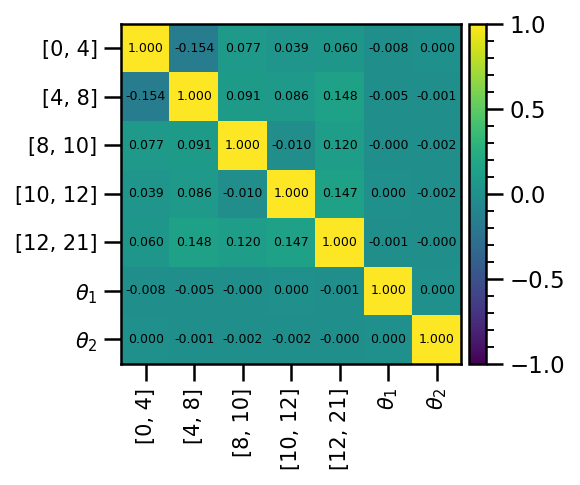

In [21]:
correlation_matrix = result.covariance / np.outer(
    result.covariance.diagonal()**0.5, result.covariance.diagonal()**0.5)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
mat = ax.imshow(correlation_matrix, vmin=-1, vmax=1)

ticklabels = [f"[{l}, {u}]" for l, u in legacy_bins] + [r"$\theta_1$", r"$\theta_2$"]

ax.set_xticks(range(len(result.x)), minor=False)
ax.set_xticklabels(ticklabels, rotation='vertical', fontsize=10)
ax.set_yticks(range(len(result.x)))
ax.set_yticklabels(ticklabels, rotation='horizontal', fontsize=10)
ax.minorticks_off()

# Loop over data dimensions and create text annotations.
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j, i, "{:.3f}".format(correlation_matrix[i, j]),
                       ha="center", va="center", color="black", fontsize=6)

fig.colorbar(mat, cax=cax, orientation='vertical')
plt.savefig("../legacy_spectra/legacy_spectrum_omega_model_dependence.pdf")
plt.show()
plt.close()

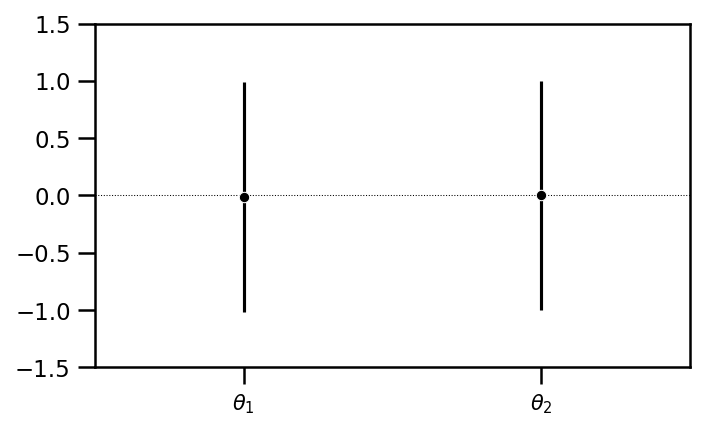

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)

ax.errorbar(range(len(result.x[5:])), result.x[5:],
            yerr=result.covariance.diagonal()[5:]**0.5,
            marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
            ls='', lw=lw, color='black', label='Nuisance Parameter')

ax.axhline(0, lw=0.5, ls="dotted", color="black")

ax.set_xlim(-0.5, 1.5)
ax.set_xticks(range(len(result.x[5:])))
ax.set_xticklabels([r"$\theta_1$", r"$\theta_2$"], rotation='horizontal', fontsize=10)
ax.set_ylim(-1.5, 1.5)
ax.minorticks_off()

plt.tight_layout()
plt.show()
plt.close()

In [23]:
legacy_central = result.x[:5]
legacy_covariance = result.covariance[:5, :5]

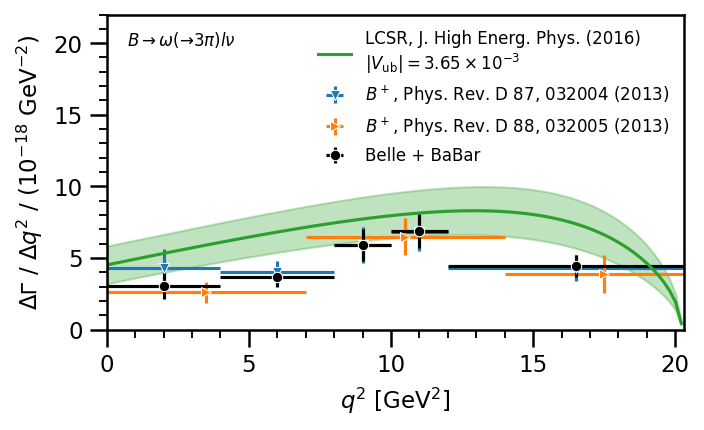

In [24]:
q2 = np.linspace(lcsr_BToVLNuBCL.q2min+1e-2, lcsr_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in babar_bins],
    [c for c in babar_central],
    yerr=[np.sqrt(babar_covariance[i, i]) for i in range(0, len(babar_bins))],
    xerr=[((b[1] - b[0]) / 2) for b in babar_bins],
    marker='v', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$, Phys. Rev. D 87, 032004 (2013)',
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in belle_bins],
    [c for c in belle_central],
    yerr=[np.sqrt(belle_covariance[i, i]) for i in range(0, len(belle_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in belle_bins],
    marker='>', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$, Phys. Rev. D 88, 032005 (2013)'
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

lcsr_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
lcsr_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, 0) # (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(lcsr_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:green", ls='solid',
        # label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = 3.65 \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(lcsr_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(lcsr_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(lcsr_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(lcsr_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                color="tab:green", alpha=0.3)


ax.set_xlim(0, 20.3)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \omega(\to3\pi) l \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("../legacy_spectra/legacy_spectrum_omega.png")
plt.savefig("../legacy_spectra/legacy_spectrum_omega.pdf")
plt.show()
plt.close()

In [25]:
legacy_spectrum = {
    "bins": legacy_bins.tolist(),
    "central_values": legacy_central.tolist(),
    "uncertainties": (legacy_covariance.diagonal()**0.5).tolist(),
    "covariance_matrix": legacy_covariance.tolist(),
    "correlation_matrix": (legacy_covariance / np.outer(legacy_covariance.diagonal()**0.5, legacy_covariance.diagonal()**0.5)).tolist()
}

In [26]:
os.makedirs("../legacy_spectra", exist_ok=True)

with open("../legacy_spectra/legacy_spectrum_omega.yaml", "w") as f:
    yaml.dump(legacy_spectrum, f)